#Check GPU available

In [4]:
!nvidia-smi

Tue Dec 16 20:18:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Data Analysis & Preprocessing

## Step 1 - Data Loading

The dataset [ LamaH-CE_daily](https://zenodo.org/record/5153305/files/2_LamaH-CE_daily.tar.gz?download=1) was locally sampled, due to the memory constraints. The sampled dataset is loaded as a .zip file, and later extracted.

In [5]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/ID_10.csv       
  inflating: dataset/ID_110.csv      
  inflating: dataset/ID_114.csv      
  inflating: dataset/ID_156.csv      
  inflating: dataset/ID_157.csv      
  inflating: dataset/ID_165.csv      
  inflating: dataset/ID_178.csv      
  inflating: dataset/ID_184.csv      
  inflating: dataset/ID_186.csv      
  inflating: dataset/ID_222.csv      
  inflating: dataset/ID_234.csv      
  inflating: dataset/ID_242.csv      
  inflating: dataset/ID_244.csv      
  inflating: dataset/ID_27.csv       
  inflating: dataset/ID_278.csv      
  inflating: dataset/ID_282.csv      
  inflating: dataset/ID_289.csv      
  inflating: dataset/ID_290.csv      
  inflating: dataset/ID_294.csv      
  inflating: dataset/ID_299.csv      
  inflating: dataset/ID_310.csv      
  inflating: dataset/ID_321.csv      
  inflating: dataset/ID_322.csv      
  inflating: dataset/ID_328.csv      
  inflating: dataset/ID_330.csv      
  infl

In [6]:
import pandas as pd
import os

df_list = []
station_ids = []

# Assuming the filename itself contains a unique Station ID
for file in os.listdir("dataset/"):
    # Extract the Station ID from the filename (e.g., "station_001.csv" -> "001")
    station_id = os.path.splitext(file)[0].split('_')[-1]

    df_tmp = pd.read_csv(os.path.join("dataset", file), sep=";")

    # Check if a 'Station_ID' column exists, otherwise create it
    if 'station_id' not in df_tmp.columns:
        df_tmp['station_id'] = station_id

    df_list.append(df_tmp)

# Concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

# Convert the date column to datetime objects
df["date"] = pd.to_datetime(
    df.rename(columns={"YYYY": "year", "MM": "month", "DD": "day"})[["year","month","day"]]
)

# IMPORTANT: Set a MultiIndex to simultaneously track time and space
df = df.set_index(['date', 'station_id']).sort_index()

print("--- MultiIndex DataFrame Head (3D structure proxy) ---")
print(df.head(6))

--- MultiIndex DataFrame Head (3D structure proxy) ---
                       YYYY  MM  DD  DOY  2m_temp_max  2m_temp_mean  \
date       station_id                                                 
1981-01-01 10          1981   1   1    1         -2.5          -5.4   
           110         1981   1   1    1         -1.1          -5.5   
           114         1981   1   1    1         -5.6          -9.0   
           156         1981   1   1    1          2.2          -0.1   
           157         1981   1   1    1          1.8          -0.9   
           165         1981   1   1    1          3.3           1.0   

                       2m_temp_min  2m_dp_temp_max  2m_dp_temp_mean  \
date       station_id                                                 
1981-01-01 10                 -9.4            -4.2             -8.2   
           110               -11.7            -3.4             -8.0   
           114               -12.7           -10.1            -13.7   
           156       

## Step 2 - Null Value Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1424400 entries, (Timestamp('1981-01-01 00:00:00'), '10') to (Timestamp('2019-12-31 00:00:00'), '96')
Data columns (total 25 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   YYYY                     1424400 non-null  int64  
 1   MM                       1424400 non-null  int64  
 2   DD                       1424400 non-null  int64  
 3   DOY                      1424400 non-null  int64  
 4   2m_temp_max              1424400 non-null  float64
 5   2m_temp_mean             1424400 non-null  float64
 6   2m_temp_min              1424400 non-null  float64
 7   2m_dp_temp_max           1424400 non-null  float64
 8   2m_dp_temp_mean          1424400 non-null  float64
 9   2m_dp_temp_min           1424400 non-null  float64
 10  10m_wind_u               1424400 non-null  float64
 11  10m_wind_v               1424400 non-null  float64
 12  fcst_alb                 1

In [8]:
df.isnull().sum()

,0
YYYY,0
MM,0
DD,0
DOY,0
2m_temp_max,0
2m_temp_mean,0
2m_temp_min,0
2m_dp_temp_max,0
2m_dp_temp_mean,0
2m_dp_temp_min,0


The dataset doesn't contain None, NA and other formal marks for missing values. Since all columns are numeric and no palceholder values were present, no additional missing-value cleaning was required.

In [9]:
df.describe()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,swe,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4
count,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,...,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06
mean,2.000000e+03,6.523168e+00,1.572894e+01,1.831156e+02,1.035173e+01,6.216180e+00,2.108277e+00,4.845897e+00,2.521794e+00,2.091667e-02,...,9.968591e+01,3.749061e+02,1.106735e+02,8.167603e+01,4.933235e+01,9.099415e+04,1.511559e+00,3.310373e+00,3.657362e-01,3.892732e-01
std,1.125407e+01,3.448639e+00,8.799800e+00,1.054331e+02,8.983718e+00,8.502150e+00,8.194964e+00,7.805372e+00,8.017046e+00,8.477896e+00,...,3.423062e+02,1.970900e+02,7.247440e+01,2.674597e+01,2.207632e+01,5.846044e+03,1.353567e+00,5.575126e+00,6.257798e-02,5.613992e-02
min,1.981000e+03,1.000000e+00,1.000000e+00,1.000000e+00,-2.490000e+01,-3.040000e+01,-3.790000e+01,-3.480000e+01,-3.770000e+01,-4.180000e+01,...,0.000000e+00,4.000000e+00,1.000000e+00,-1.800000e+01,-3.000000e+01,7.070400e+04,-1.820000e+00,0.000000e+00,1.500000e-01,2.200000e-01
25%,1.990000e+03,4.000000e+00,8.000000e+00,9.200000e+01,3.400000e+00,1.000000e-01,-3.100000e+00,-6.000000e-01,-2.800000e+00,-5.300000e+00,...,0.000000e+00,2.000000e+02,4.500000e+01,6.500000e+01,3.300000e+01,8.914500e+04,2.800000e-01,4.000000e-02,3.300000e-01,3.600000e-01
50%,2.000000e+03,7.000000e+00,1.600000e+01,1.830000e+02,1.050000e+01,6.400000e+00,2.300000e+00,5.300000e+00,3.000000e+00,7.000000e-01,...,1.200000e-01,3.610000e+02,9.700000e+01,8.400000e+01,5.000000e+01,9.306000e+04,1.140000e+00,8.900000e-01,3.700000e-01,3.900000e-01
75%,2.010000e+03,1.000000e+01,2.300000e+01,2.740000e+02,1.740000e+01,1.300000e+01,8.500000e+00,1.100000e+01,8.800000e+00,6.600000e+00,...,3.098000e+01,5.460000e+02,1.700000e+02,1.010000e+02,6.600000e+01,9.490500e+04,2.620000e+00,4.310000e+00,4.000000e-01,4.100000e-01
max,2.019000e+03,1.200000e+01,3.100000e+01,3.660000e+02,3.690000e+01,2.970000e+01,2.380000e+01,2.570000e+01,2.110000e+01,2.000000e+01,...,3.292600e+03,8.330000e+02,3.060000e+02,1.920000e+02,1.190000e+02,1.012320e+05,8.680000e+00,1.239700e+02,7.300000e-01,7.300000e-01


The distribution is presented to see if any numerical value is used to mark missing values. There are no extreme values detected, that would be used in this purpose.

## Step 3 - Statistical Analysis

In [10]:
print(df.columns)

Index(['YYYY', 'MM', 'DD', 'DOY', '2m_temp_max', '2m_temp_mean', '2m_temp_min',
       '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u',
       '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe',
       'surf_net_solar_rad_max', 'surf_net_solar_rad_mean',
       'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press',
       'total_et', 'prec', 'volsw_123', 'volsw_4'],
      dtype='object')


### Columns grouping

Columns are grouped by their meaning, to make data visualization more meaningful. We find columns related to time, temperature and atmosphere, raditaion and vegetation, and hydrology.

In [11]:
time_columns = ["YYYY","MM","DD","DOY"]
temp_atm_columns = ['2m_temp_max', '2m_temp_mean', '2m_temp_min',
       '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min','10m_wind_u',
       '10m_wind_v','surf_press']
rad_veg_columns = ['surf_net_solar_rad_max', 'surf_net_solar_rad_mean',
       'surf_net_therm_rad_max', 'surf_net_therm_rad_mean','fcst_alb','lai_high_veg', 'lai_low_veg']
hyd_columns = ["prec","swe","total_et","volsw_123","volsw_4"]


### Statics per column type

In [12]:
df[temp_atm_columns].describe()


,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,surf_press
count,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06
mean,1.035173e+01,6.216180e+00,2.108277e+00,4.845897e+00,2.521794e+00,2.091667e-02,4.829304e-01,4.776846e-02,9.099415e+04
std,8.983718e+00,8.502150e+00,8.194964e+00,7.805372e+00,8.017046e+00,8.477896e+00,1.520142e+00,1.077783e+00,5.846044e+03
min,-2.490000e+01,-3.040000e+01,-3.790000e+01,-3.480000e+01,-3.770000e+01,-4.180000e+01,-6.200000e+00,-7.500000e+00,7.070400e+04
25%,3.400000e+00,1.000000e-01,-3.100000e+00,-6.000000e-01,-2.800000e+00,-5.300000e+00,-3.000000e-01,-6.000000e-01,8.914500e+04
50%,1.050000e+01,6.400000e+00,2.300000e+00,5.300000e+00,3.000000e+00,7.000000e-01,3.000000e-01,1.000000e-01,9.306000e+04
75%,1.740000e+01,1.300000e+01,8.500000e+00,1.100000e+01,8.800000e+00,6.600000e+00,1.200000e+00,7.000000e-01,9.490500e+04
max,3.690000e+01,2.970000e+01,2.380000e+01,2.570000e+01,2.110000e+01,2.000000e+01,8.900000e+00,7.500000e+00,1.012320e+05


In [13]:
df[rad_veg_columns].describe()

,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,fcst_alb,lai_high_veg,lai_low_veg
count,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06
mean,3.749061e+02,1.106735e+02,8.167603e+01,4.933235e+01,2.290496e-01,2.555043e+00,1.918373e+00
std,1.970900e+02,7.247440e+01,2.674597e+01,2.207632e+01,1.440769e-01,1.003599e+00,8.231628e-01
min,4.000000e+00,1.000000e+00,-1.800000e+01,-3.000000e+01,7.000000e-02,8.000000e-01,0.000000e+00
25%,2.000000e+02,4.500000e+01,6.500000e+01,3.300000e+01,1.300000e-01,1.700000e+00,1.300000e+00
50%,3.610000e+02,9.700000e+01,8.400000e+01,5.000000e+01,1.600000e-01,2.500000e+00,2.100000e+00
75%,5.460000e+02,1.700000e+02,1.010000e+02,6.600000e+01,3.300000e-01,3.300000e+00,2.600000e+00
max,8.330000e+02,3.060000e+02,1.920000e+02,1.190000e+02,8.200000e-01,5.100000e+00,3.200000e+00


In [14]:
df[hyd_columns].describe()

,prec,swe,total_et,volsw_123,volsw_4
count,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06,1.424400e+06
mean,3.310373e+00,9.968591e+01,1.511559e+00,3.657362e-01,3.892732e-01
std,5.575126e+00,3.423062e+02,1.353567e+00,6.257798e-02,5.613992e-02
min,0.000000e+00,0.000000e+00,-1.820000e+00,1.500000e-01,2.200000e-01
25%,4.000000e-02,0.000000e+00,2.800000e-01,3.300000e-01,3.600000e-01
50%,8.900000e-01,1.200000e-01,1.140000e+00,3.700000e-01,3.900000e-01
75%,4.310000e+00,3.098000e+01,2.620000e+00,4.000000e-01,4.100000e-01
max,1.239700e+02,3.292600e+03,8.680000e+00,7.300000e-01,7.300000e-01


### Distribution per column type

In [15]:
import matplotlib.pyplot as plt

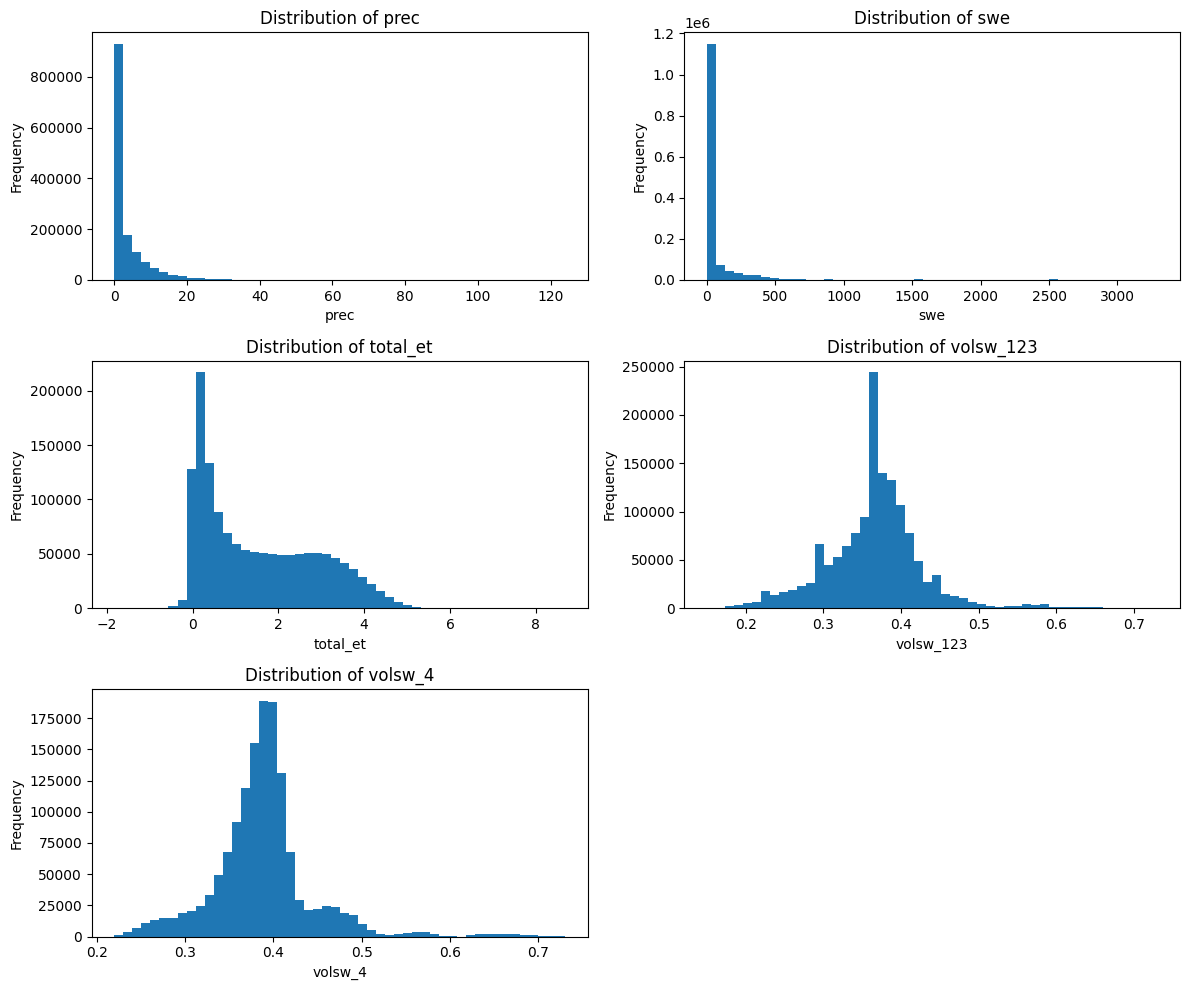

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(hyd_columns):
    axes[i].hist(df[col], bins=50)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")


axes[-1].axis("off")

plt.tight_layout()
plt.show()

Among these results, we don't see any outliers. The columns *prec* and *swe* have highly skewed distribution. To overcome this problem, on the *swe* column the log transformation will be applied. On the other column *normalization* will be applied. The *prec* as the target column won't be transformed.

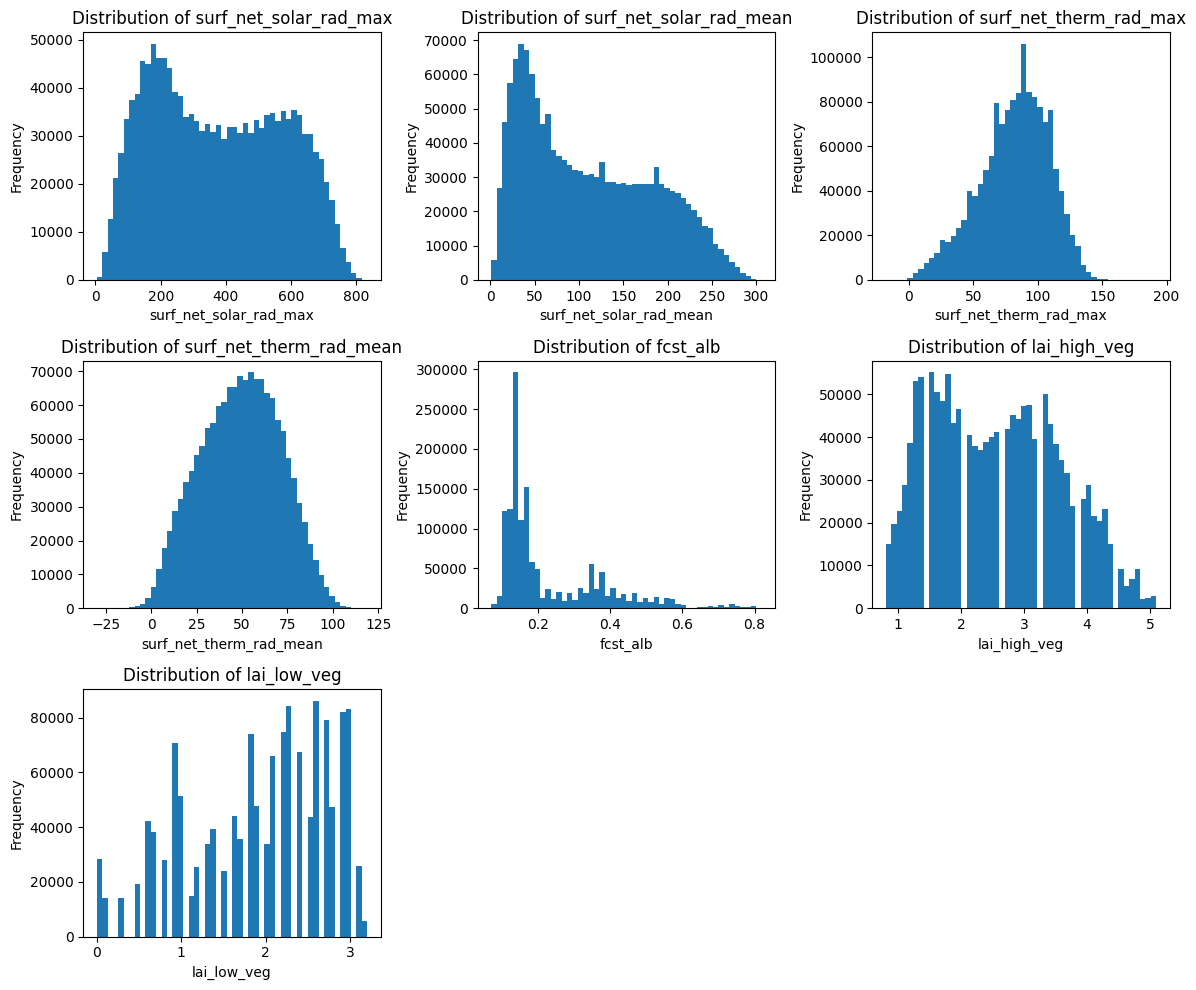

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(rad_veg_columns):
    axes[i].hist(df[col], bins=50)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

axes[-2].axis("off")
axes[-1].axis("off")

plt.tight_layout()
plt.show()

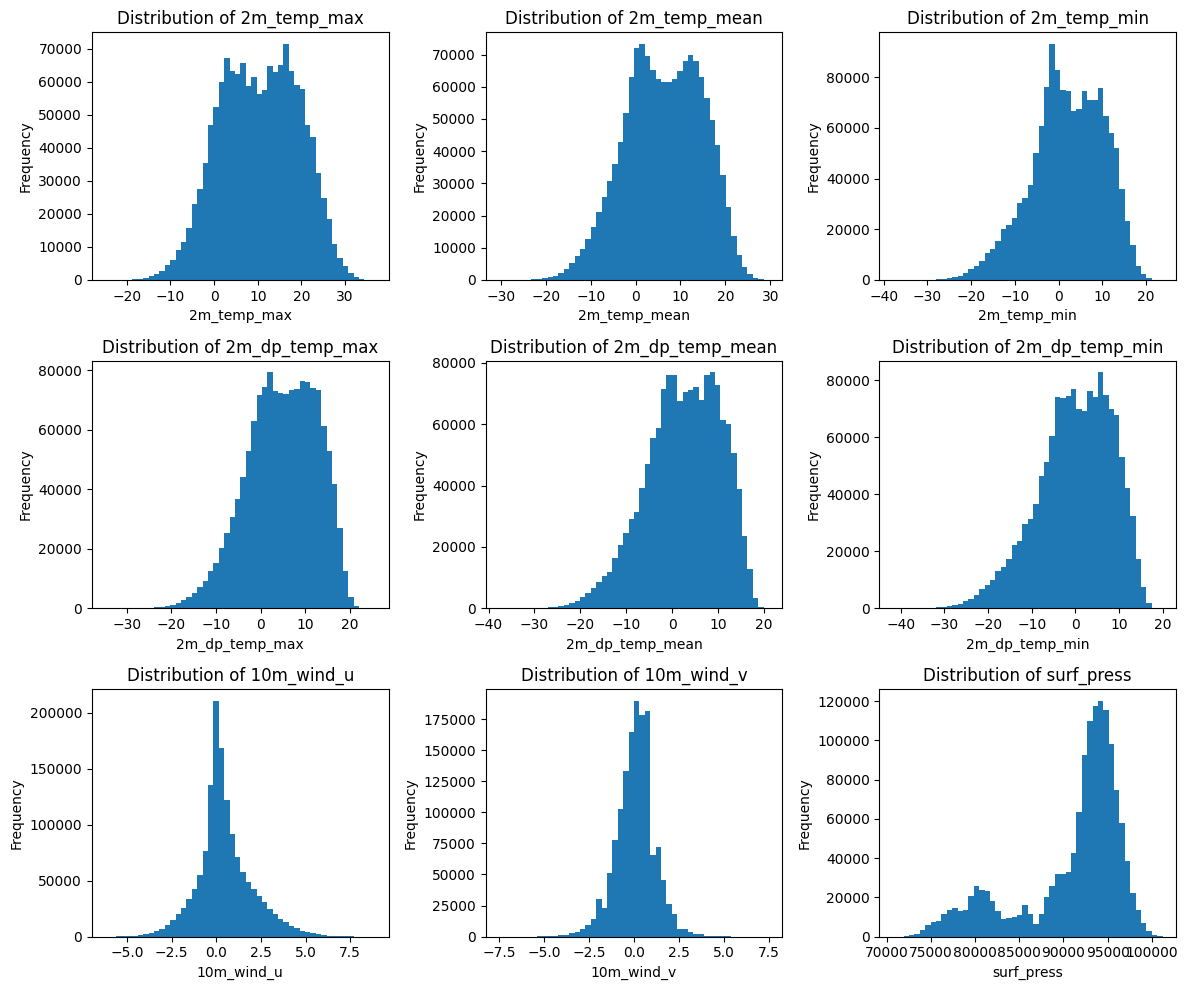

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(temp_atm_columns):
    axes[i].hist(df[col], bins=50)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

On all these columns z-score standardization will be applied, because of theri distribution, that mostly isn't skewed.

### Correlations

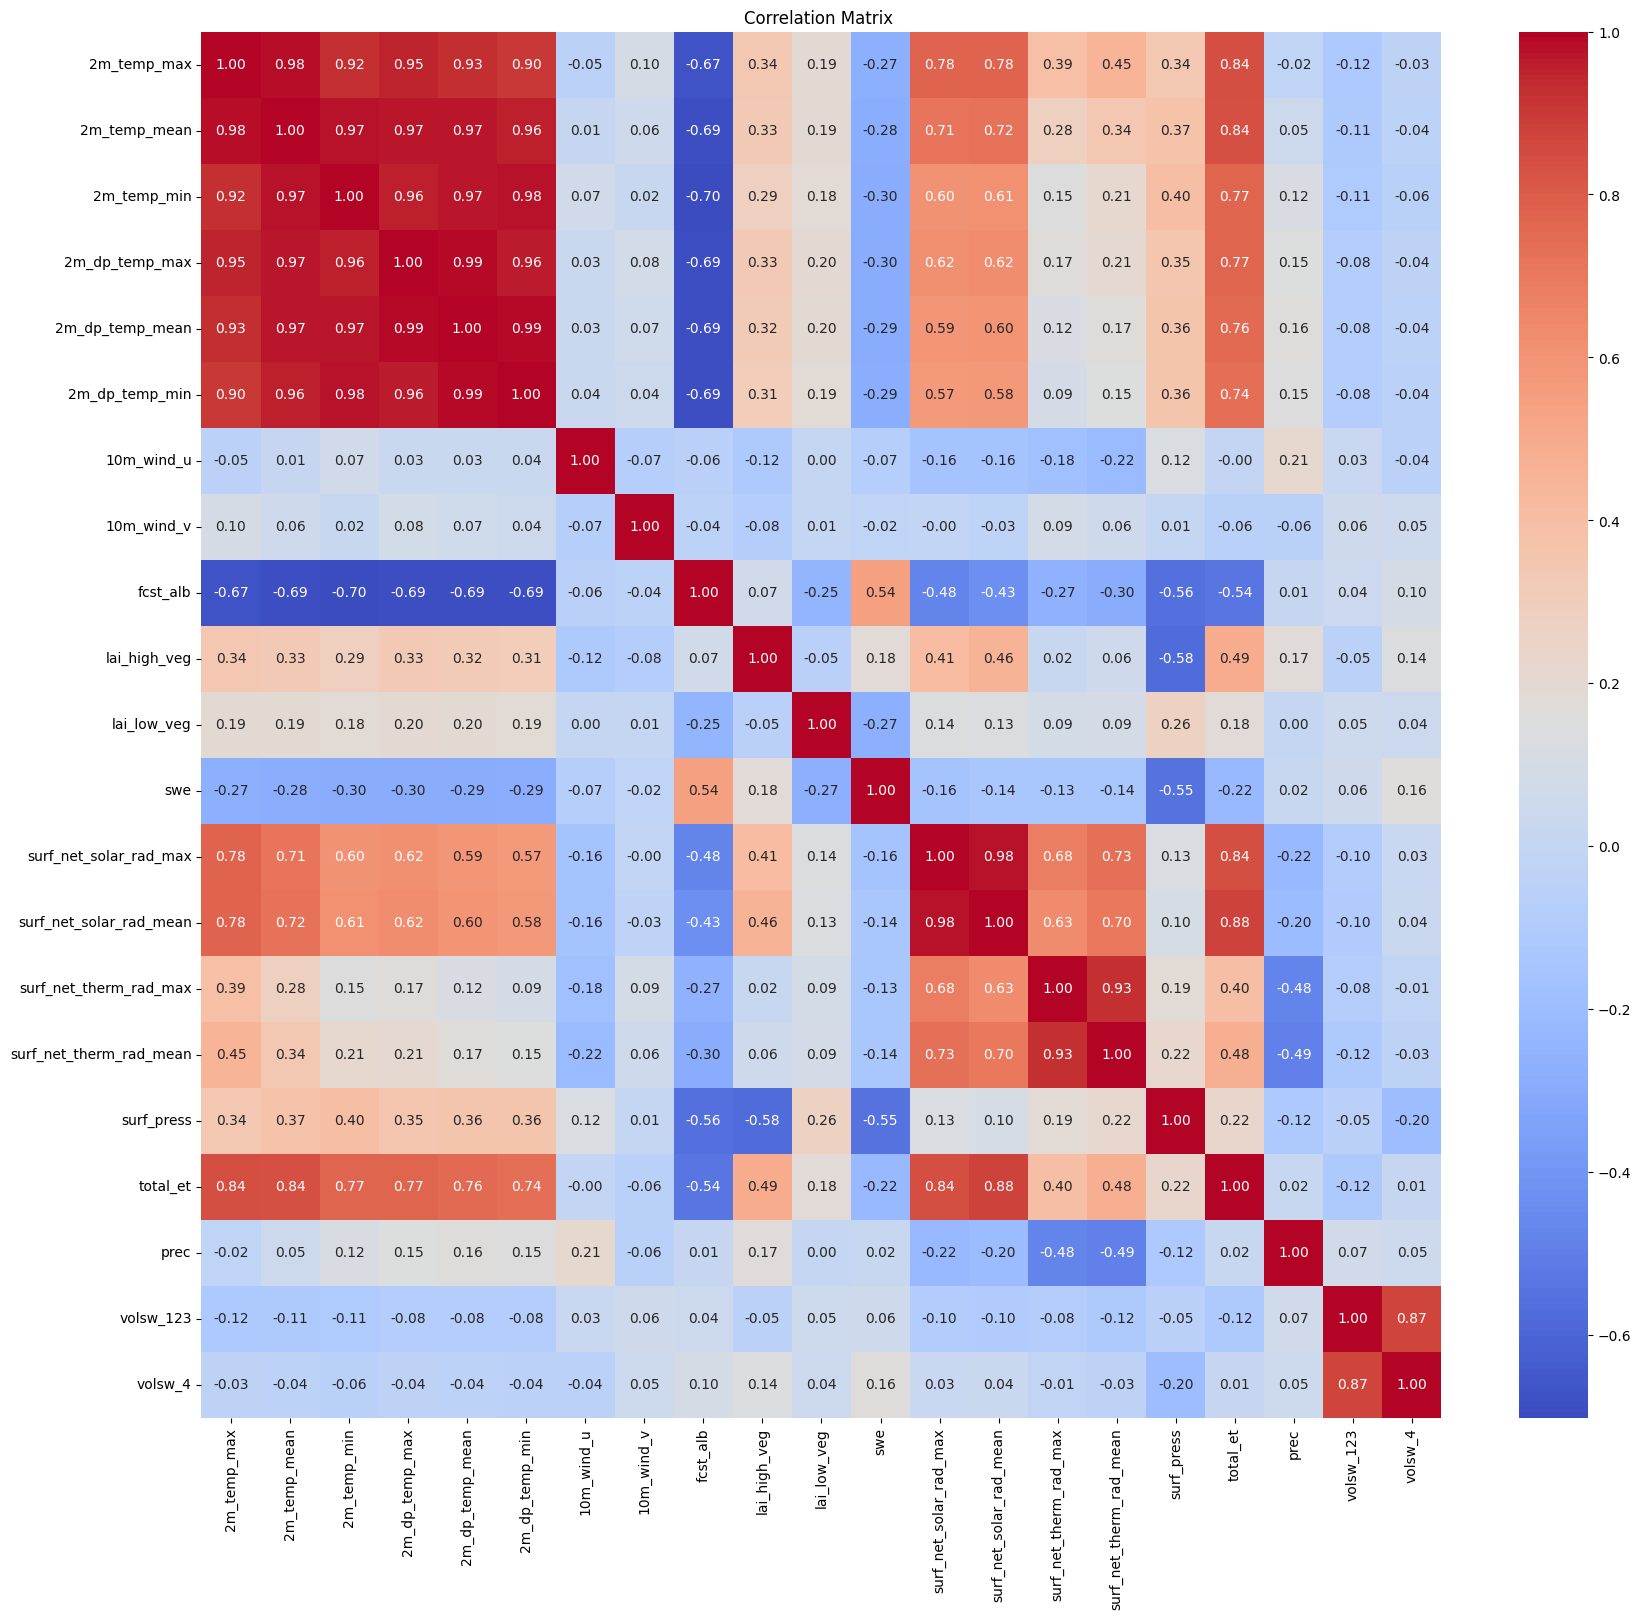

In [19]:
import seaborn as sns
corr_vars = df.columns.tolist()
for col in time_columns:
  corr_vars.remove(col)
corr_matrix = df[corr_vars].corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix ")
plt.show()

## Step 4 - Data Preprocessing

According to the correlation matrix plot some extreme correlations can be seen as can be expected:
* 2m_temp(mean, max, min) - keeping mean.
* 2m_dp_temp(mean, max, min) - keeping mean.
* surf_net_solar_rad(mean, max) - keeping mean.
* surf_net_therm_rad(mean, max) - keeping mean.

In [20]:
col_to_drop = ["2m_temp_max","2m_temp_min","2m_dp_temp_max","2m_dp_temp_min","surf_net_therm_rad_max","surf_net_solar_rad_max"]

In [21]:
df.head()

YYYY  MM  DD  DOY  2m_temp_max  2m_temp_mean  \
date       station_id                                                 
1981-01-01 10          1981   1   1    1         -2.5          -5.4   
           110         1981   1   1    1         -1.1          -5.5   
           114         1981   1   1    1         -5.6          -9.0   
           156         1981   1   1    1          2.2          -0.1   
           157         1981   1   1    1          1.8          -0.9   

                       2m_temp_min  2m_dp_temp_max  2m_dp_temp_mean  \
date       station_id                                                 
1981-01-01 10                 -9.4            -4.2             -8.2   
           110               -11.7            -3.4             -8.0   
           114               -12.7           -10.1            -13.7   
           156                -2.6            -0.3             -3.3   
           157                -5.0            -0.3             -3.9   

                       2m_dp_temp_min  ...      swe  surf_net_solar_rad_max  \
date       station_id                  ...                                    
1981-01-01 10                   -13.5  ...   173.91                      94   
           110                  -13.6  ...   190.62                      88   
           114                  -16.7  ...  1827.46                     102   
           156                   -6.5  ...    61.00                      97   
           157                   -8.6  ...   100.23                      84   

                       surf_net_solar_rad_mean  surf_net_therm_rad_max  \
date       station_id                                                    
1981-01-01 10                               13                      45   
           110                              15                      53   
           114                              18                      39   
           156                              15                      63   
           157                              13                      62   

                       surf_net_therm_rad_mean  surf_press  total_et  prec  \
date       station_id                                                        
1981-01-01 10                               17     89347.0     -0.09  9.01   
           110                              22     90219.0     -0.09  9.85   
           114                              20     79410.0     -0.05  6.91   
           156                              34     94382.0      0.63  6.88   
           157                              28     94122.0      0.43  7.00   

                       volsw_123  volsw_4  
date       station_id                      
1981-01-01 10               0.33     0.40  
           110              0.34     0.40  
           114              0.40     0.47  
           156              0.41     0.41  
           157              0.40     0.40  

[5 rows x 25 columns]

In [22]:
df = df.drop(col_to_drop,axis = 1)

Hihgly skewed swe columns

In [23]:
df

YYYY  MM  DD  DOY  2m_temp_mean  2m_dp_temp_mean  \
date       station_id                                                     
1981-01-01 10          1981   1   1    1          -5.4             -8.2   
           110         1981   1   1    1          -5.5             -8.0   
           114         1981   1   1    1          -9.0            -13.7   
           156         1981   1   1    1          -0.1             -3.3   
           157         1981   1   1    1          -0.9             -3.9   
...                     ...  ..  ..  ...           ...              ...   
2019-12-31 831         2019  12  31  365          -0.6             -3.9   
           833         2019  12  31  365          -0.4             -3.9   
           873         2019  12  31  365           1.9             -3.0   
           89          2019  12  31  365          -2.9             -6.2   
           96          2019  12  31  365          -5.8            -10.7   

                       10m_wind_u  10m_wind_v  fcst_alb  lai_high_veg  \
date       station_id                                                   
1981-01-01 10                 0.8         0.6      0.48           2.7   
           110                2.1        -0.1      0.38           1.7   
           114                0.7        -0.4      0.54           2.4   
           156                5.2        -0.2      0.43           2.0   
           157                4.6        -0.2      0.51           2.3   
...                           ...         ...       ...           ...   
2019-12-31 831                1.2         0.2      0.27           1.2   
           833                1.2         0.3      0.26           1.2   
           873                3.3        -1.4      0.14           1.3   
           89                 0.2         1.0      0.39           1.8   
           96                 0.1         0.4      0.52           3.0   

                       lai_low_veg      swe  surf_net_solar_rad_mean  \
date       station_id                                                  
1981-01-01 10                  1.8   173.91                       13   
           110                 2.1   190.62                       15   
           114                 0.8  1827.46                       18   
           156                 2.6    61.00                       15   
           157                 2.5   100.23                       13   
...                            ...      ...                      ...   
2019-12-31 831                 2.7     9.87                       28   
           833                 2.7     9.21                       28   
           873                 2.6     1.90                       28   
           89                  2.7   126.37                       40   
           96                  1.3   516.41                       34   

                       surf_net_therm_rad_mean  surf_press  total_et  prec  \
date       station_id                                                        
1981-01-01 10                               17     89347.0     -0.09  9.01   
           110                              22     90219.0     -0.09  9.85   
           114                              20     79410.0     -0.05  6.91   
           156                              34     94382.0      0.63  6.88   
           157                              28     94122.0      0.43  7.00   
...                                        ...         ...       ...   ...   
2019-12-31 831                              38     95810.0      0.19  0.14   
           833                              39     96189.0      0.19  0.13   
           873                              47     96006.0      0.21  0.07   
           89                               47     89680.0      0.00  0.00   
           96                               42     81840.0     -0.02  0.00   

                       volsw_123  volsw_4  
date       station_id                      
1981-01-01 10               0.33     0.40  
           11

### Creating Train-Validation-Test splits

### Scaling values

In [24]:
from sklearn.preprocessing import StandardScaler

cols_x = df.columns.tolist()
cols_y = 'prec'
cols_x.remove(cols_y)

# Separate features
df_features = df[cols_x]
df_target = df[cols_y].unstack(level='station_id') # Pivot the target for sequence generation

# Normalize the Features (Fit only on training data, but for example, we use the whole set)
scaler = StandardScaler()
df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=cols_x,
    index=df_features.index
)

# Pivot the features back to a format where Time is the main index
# This creates a large, time-indexed DataFrame where each day is a matrix of (100 Stations x Features)
# This is the 2D slice that will be sequenced later.
time_station_feature_matrix = df_features_scaled.unstack(level='station_id')

print("\n--- Time-Indexed, Station-Pivoted Data Head ---")
print(time_station_feature_matrix.head())


# n = len(df)
# train_end = int(0.70 * n)
# val_end   = int(0.85 * n)

# train_df = time_station_feature_matrix.iloc[:train_end]
# val_df   = time_station_feature_matrix.iloc[train_end:val_end]
# test_df  = time_station_feature_matrix.iloc[val_end:]



--- Time-Indexed, Station-Pivoted Data Head ---
                YYYY                                                    \
station_id        10       110       114       156       157       165   
date                                                                     
1981-01-01 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279   
1981-01-02 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279   
1981-01-03 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279   
1981-01-04 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279   
1981-01-05 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279 -1.688279   

                                                    ...   volsw_4            \
station_id       178       184       186       222  ...       800       807   
date                                                ...                       
1981-01-01 -1.688279 -1.688279 -1.688279 -1.688279  ...  1.437958  1.081705   
1981-01-02 -1.688279 -1.688279 -1.688279 -

#### Save to csv

In [25]:
time_station_feature_matrix.to_csv("time_station_feature_matrix", index=False)

In [26]:
from google.colab import files

# files.download("X_train.csv")
# files.download("y_train.csv")
# files.download("X_val.csv")
# files.download("y_val.csv")
# files.download("X_test.csv")
# files.download("y_test.csv")


# Forecasting Models

## Helpers

### Evaluation helpers

In [27]:
def calculate_naive_t1_baseline(Y_test):
    """Calculates the Naive (t-1) prediction for the S stations."""

    Y_test_last = Y_test[-1, :]

    # Naive Val Prediction:
    Y_test_naive = np.roll(Y_test, shift=1, axis=0)
    Y_test_naive[0, :] = Y_test_last

    return Y_test_naive

#### Plot

In [39]:
def plot(y_pred, y_test, model_name="Hybrid LSTM-CNN", plot_station_index=0, save_dir='results'):
  y_test_flat = y_test.flatten()
  y_pred_flat = y_pred.flatten()

  # --- 1. AGGREGATE NUMERICAL METRICS ---
  mse = mean_squared_error(y_test_flat, y_pred_flat)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test_flat, y_pred_flat)
  r2 = r2_score(y_test_flat, y_pred_flat)

  print(f"--- Aggregate Metrics for {model_name} (All Stations & Times) ---")
  print(f"Mean Squared Error (MSE): {mse:.4f}")
  print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
  print(f"Mean Absolute Error (MAE): {mae:.4f}")
  print(f"R-squared Score (R2): {r2:.4f}")
  print("-" * 50)

  # --- 2. VISUAL ANALYSIS: Plot True vs. Predicted for ONE STATION ---

  # Extract the time series for the selected station
  try:
      y_test_station = y_test[:, plot_station_index]
      y_pred_station = y_pred[:, plot_station_index]
  except IndexError:
      print(f"Error: Station index {plot_station_index} out of bounds (Max index is {y_test.shape[1] - 1}).")
      return

  # Calculate single-station RMSE for the plot title
  station_rmse = np.sqrt(mean_squared_error(y_test_station, y_pred_station))

  plt.figure(figsize=(14, 7))
  plt.plot(y_test_station, label=f'True Values', color='blue', linewidth=1)
  plt.plot(y_pred_station, label=f'Predicted Values', color='red', linestyle='--', linewidth=1)

  plt.title(f'{model_name} Forecast: True vs. Predicted (Station {plot_station_index})')
  plt.suptitle(f'Aggregate RMSE (All Stations): {rmse:.4f} | Station RMSE: {station_rmse:.4f}', fontsize=12)
  plt.xlabel('Time Step (Test Period)')
  plt.ylabel('Target Value (Original Units)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for suptitle
  plot1_filename = os.path.join(save_dir, f"true_vs_predicted_{model_name}.png")
  plt.savefig(plot1_filename)
  plt.show()

  # --- 3. VISUAL ANALYSIS: Residuals for ONE STATION ---
  residuals_station = y_test_station - y_pred_station

  plt.figure(figsize=(14, 3))
  plt.plot(residuals_station, label='Residuals (Error)', color='green', linewidth=1)
  plt.axhline(0, color='red', linestyle='-')
  plt.title(f'Residual Plot (Errors Over Time) for Station {plot_station_index}')
  plt.xlabel('Time Step (Test Period)')
  plt.ylabel('Residual Value (True - Predicted)')
  plt.legend()
  plt.grid(True)
  plot1_filename = os.path.join(save_dir, f"residuals_plot_{model_name}.png")
  plt.savefig(plot1_filename)
  plt.show()



  metrics = {
    "mse": mse,
    "rmse": rmse,
    "mae": mae,
    "r2": r2
  }

  return metrics

#### Evaluation

In [29]:
import os

def evaluate_and_plot(y_pred, y_test, model_name="Hybrid LSTM-CNN", plot_station_index=0, save_dir='results'):
    """
    Calculates aggregate metrics and plots the time series for a single station.
    Args:
        y_pred (np.ndarray): Unscaled predictions (Samples x Stations).
        y_test (np.ndarray): Unscaled true targets (Samples x Stations).
        model_name (str): Name for output and titles.
        plot_station_index (int): Index of the station to plot (e.g., 0 to N-1).
    """
    os.makedirs(save_dir, exist_ok=True)

    metrics_model = plot(y_pred, y_test, model_name, plot_station_index, save_dir)
    metrics_baseline_t1 = plot(calculate_naive_t1_baseline(y_test), y_test, 'naive (t-1)', plot_station_index, save_dir)

    metrics_df = pd.DataFrame([metrics_model, metrics_baseline_t1])

    # 5. Add a new column named 'Model' to the DataFrame
    metrics_df['Model'] = [model_name, 'naive (t-1)']

    # Reorder columns to have 'Model' first for better readability
    metrics_df = metrics_df[['Model', 'mse', 'rmse', 'mae', 'r2']]
    metrics_df.transpose()

    metrics_filename = os.path.join(save_dir, f"{model_name}_evaluation_metrics.csv")
    metrics_df.to_csv(f"metrics_{model_name.replace(' ', '_').lower()}.csv", index=False)
    print(f"{model_name} evaluation metrics saved to {metrics_filename}")

    print("\n--- Overall Performance Comparison ---")
    print(metrics_df.to_string(index=False))
    print("-" * 50)

#### Early stop callback

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # 1. Metric to monitor (usually validation loss)
    patience=20,         # 2. Number of epochs to wait after min loss is achieved
    verbose=1,           # 3. Print a message when training stops
    mode='min',          # 4. Stop when the monitored quantity stops decreasing (i.e., we look for a minimum)
    restore_best_weights=True # 5. Restore the weights from the epoch with the best 'val_loss'
)

## Step 1 - Model

### LSTM

#### Prepare input

In [31]:
import numpy as np

def create_sequences(data, target, lookback=7, forecast_horizon=1):
    """
    Transforms the 2D time-indexed data into 3D/4D input sequences and 2D/3D targets.
    """
    X, Y = [], []

    # 1. Get the list of all dates in the data
    dates = data.index.unique(level='date')

    for i in range(len(dates) - lookback - forecast_horizon + 1):

        # Input (X): Data from time t to t + lookback - 1
        x_indices = dates[i : i + lookback]

        # Target (Y): Target value at time t + lookback + forecast_horizon - 1
        y_index = dates[i + lookback + forecast_horizon - 1]

        # Reshape X: (Lookback_Days, Stations * Features) -> (Lookback_Days, Stations, Features)
        # Assuming the columns are ordered as (Feature1_St1, Feature1_St2, ..., FeatureN_StM)
        x_data_flat = data.loc[x_indices]

        # Reshape the flat data into the desired 3D tensor:
        # (Lookback * Stations, Features) -> (Lookback, Stations, Features)
        x_data_3d = x_data_flat.values.reshape(lookback, -1, len(cols_x))

        y_data = target.loc[y_index].values # Target for all stations at the forecast date

        X.append(x_data_3d)
        Y.append(y_data)

    return np.array(X), np.array(Y)

# def create_sequences(X, y, look_back):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - look_back):
#         X_seq.append(X.iloc[i:(i + look_back)].values)
#         y_seq.append(y.iloc[i + look_back])
#     return np.array(X_seq), np.array(y_seq)

In [32]:
LOOKBACK_DAYS = 7 # Use the last 7 days of data
FORECAST_HORIZON = 1 # Predict 1 day ahead

# We need to flatten the (Station, Feature) dimensions back into a single level
# to ensure consistent ordering for reshaping later
data_for_sequence = time_station_feature_matrix.stack(level='station_id')

X_sequences, Y_targets = create_sequences(
    data=data_for_sequence,
    target=df_target,
    lookback=LOOKBACK_DAYS,
    forecast_horizon=FORECAST_HORIZON
)

# Assuming a total of N samples (rows in X_sequences)
N = X_sequences.shape[0]

# Calculate split points (example: 70/15/15 split)
train_end = int(N * 0.70)
val_end = int(N * 0.85)

# Training Set
X_train, Y_train = X_sequences[:train_end], Y_targets[:train_end]

# Validation Set
X_val, Y_val = X_sequences[train_end:val_end], Y_targets[train_end:val_end]

# Test Set
X_test, Y_test = X_sequences[val_end:], Y_targets[val_end:]

print(f"\n--- Final Data Shapes for Modeling ---")
print(f"X_sequences (Input): {X_sequences.shape}")
print(f"Y_targets (Output): {Y_targets.shape}")

print(f"X_train_seq shape: {X_train.shape}")
print(f"y_train_seq shape: {Y_train.shape}")
print(f"X_val_seq shape: {X_val.shape}")
print(f"y_val_seq shape: {Y_val.shape}")
print(f"X_test_seq shape: {X_test.shape}")
print(f"y_test_seq shape: {Y_test.shape}")

/tmp/ipython-input-616667438.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_for_sequence = time_station_feature_matrix.stack(level='station_id')



--- Final Data Shapes for Modeling ---
X_sequences (Input): (14237, 7, 100, 18)
Y_targets (Output): (14237, 100)
X_train_seq shape: (9965, 7, 100, 18)
y_train_seq shape: (9965, 100)
X_val_seq shape: (2136, 7, 100, 18)
y_val_seq shape: (2136, 100)
X_test_seq shape: (2136, 7, 100, 18)
y_test_seq shape: (2136, 100)


#### Model definition



In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Input, Dropout

N_TIMESTEPS = X_sequences.shape[1] # 7 days
N_STATIONS = X_sequences.shape[2] # 100 stations
N_FEATURES = X_sequences.shape[3] # Number of meteorological features

model = Sequential([
    # 1. Spatial Feature Extraction (TimeDistributed CNN)
    # The Conv1D slides over the N_STATIONS dimension (2 in your test case).
    # Kernel size must be less than N_STATIONS (e.g., 2 stations -> kernel size 1 or 2)
    TimeDistributed(Conv1D(
        filters=32,
        kernel_size=2, # Use kernel_size=1 or 2. Since S=2, let's use 1 to be safe for testing.
        activation='relu',
        padding='valid' # Use 'valid' for simplicity, 'same' works too but check output size
    ), input_shape=(N_TIMESTEPS, N_STATIONS, N_FEATURES)),

    # After Conv1D, the shape is (T, S_new, 64) where S_new is S or S-kernel+1

    # 2. Pooling (Optional, but often necessary if S is large)
    # Since S=2, pooling might remove too much, but let's keep it minimal
    TimeDistributed(MaxPooling1D(pool_size=2)), # Setting pool_size=1 acts as an identity function for small S.

    # 3. Flatten the spatial output to create a sequence of vectors
    TimeDistributed(Flatten()), # Shape becomes (T, S_new * 64)

    # 4. Temporal Sequence Modeling (LSTM)
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.3),

    # 5. Output Layer
    Dense(N_STATIONS)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, 7, 99, 32)      │         1,184 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 7, 49, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 7, 1568)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 1568)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │       323,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │         5,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,084 (1.26 MB)

 Trainable params: 330,084 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

#### Train

In [45]:
history = model.fit(
    X_train, Y_train,
    epochs=100, # Set a high number, but Early Stopping will stop it sooner
    batch_size=16, # Try 16, 32, or 64. Adjust based on your GPU memory.
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 33.4517 - val_loss: 27.3739
Epoch 2/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 25.7568 - val_loss: 25.6418
Epoch 3/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 25.3619 - val_loss: 25.1292
Epoch 4/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 24.1960 - val_loss: 24.9703
Epoch 5/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 23.4899 - val_loss: 25.5021
Epoch 6/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 25.4518 - val_loss: 25.2399
Epoch 7/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 23.2502 - val_loss: 25.0684
Epoch 8/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 22.4827 - val_loss: 24.6077
Epoch 9/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 22.8103 - val_loss: 24.3983
Epoch 10/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 22.7760 - val_loss: 24.8761
Epoch 11/100
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 21.7951 - val_loss: 24.2525
Epoch 12/100
312/

#### Predict


In [35]:
y_pred_scaled = model.predict(X_test)
# Apply the inverse transformation to convert predictions back to original scale
# y_pred_real = np.expm1(y_pred)
# y_test_real = np.expm1(y_test_seq)

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


#### Evaluate

Prediction array shape: (2136, 100)
Number of Stations: 100
--- Aggregate Metrics for Hybrid LSTM-CNN (All Stations & Times) ---
Mean Squared Error (MSE): 23.2070
Root Mean Squared Error (RMSE): 4.8174
Mean Absolute Error (MAE): 3.0097
R-squared Score (R2): 0.2576
--------------------------------------------------


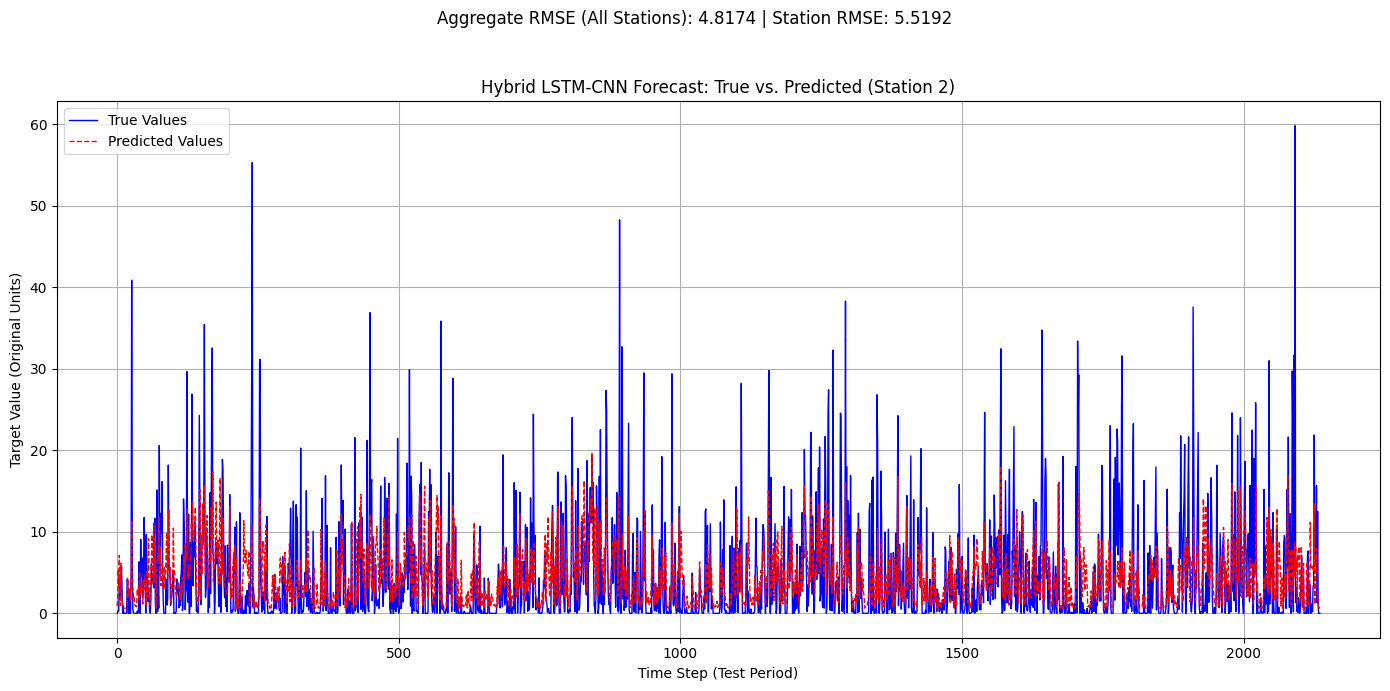

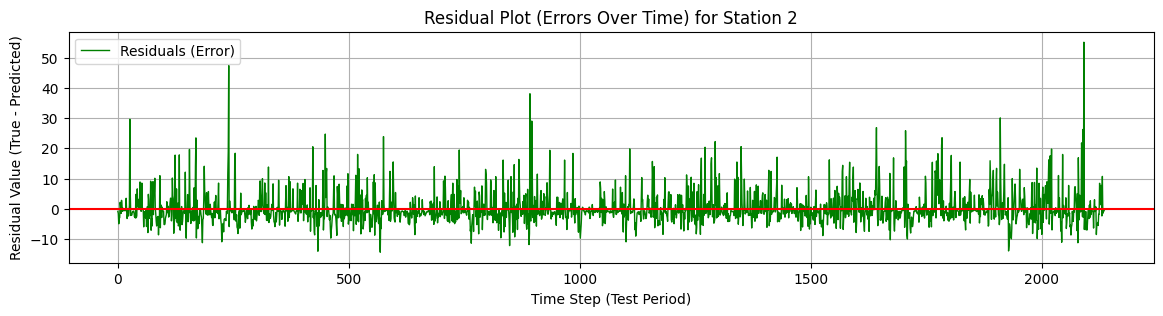

--- Aggregate Metrics for naive (t-1) (All Stations & Times) ---
Mean Squared Error (MSE): 42.2112
Root Mean Squared Error (RMSE): 6.4970
Mean Absolute Error (MAE): 3.6409
R-squared Score (R2): -0.3503
--------------------------------------------------


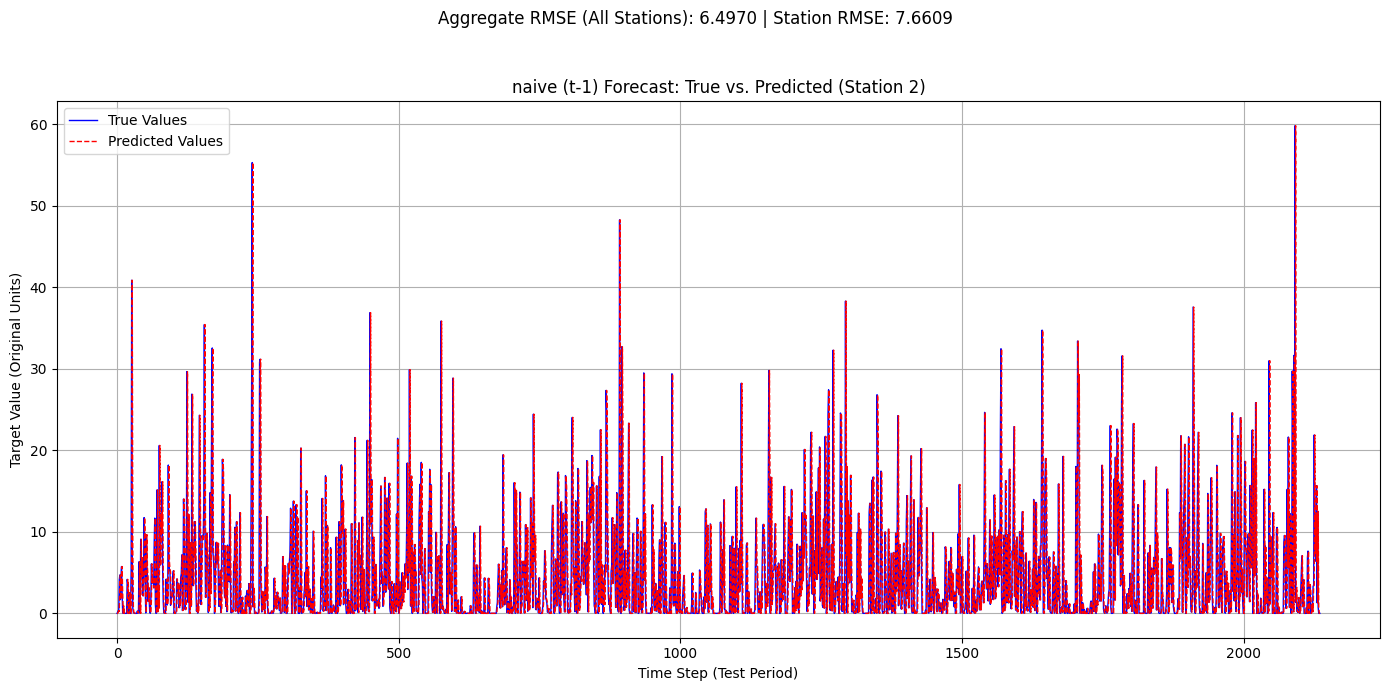

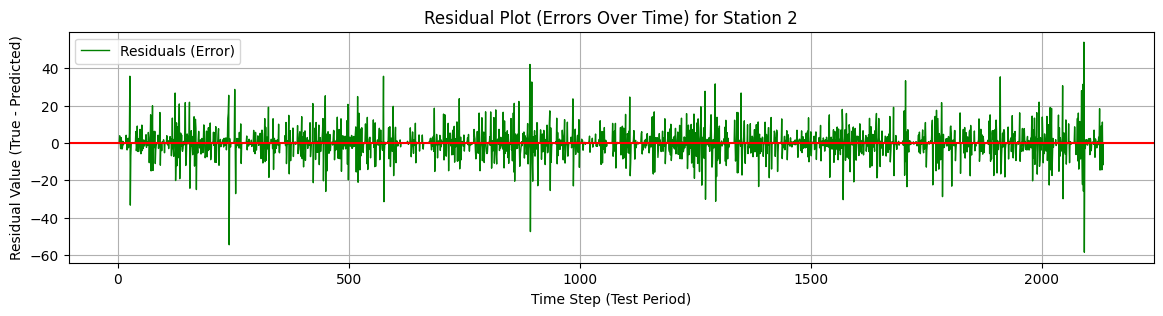

Hybrid LSTM-CNN evaluation metrics saved to results/Hybrid LSTM-CNN_evaluation_metrics.csv

--- Overall Performance Comparison ---
          Model       mse     rmse      mae        r2
Hybrid LSTM-CNN 23.207016 4.817366 3.009750  0.257620
    naive (t-1) 42.211232 6.497017 3.640932 -0.350315
--------------------------------------------------


In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Y_test holds the actual 'prec' values, which were not scaled by 'scaler'.
# y_pred_scaled are the model's predictions, which are also on the original scale of 'prec'.
# Therefore, no inverse transformation is needed here with the 'scaler' fitted on features.
y_test_unscaled = Y_test.copy() # Y_test is already in original scale
y_pred_unscaled = y_pred_scaled.copy() # Predictions are in original scale (match Y_test)

# Verify the shape is 2D (Samples x Stations)
N_STATIONS = y_test_unscaled.shape[1]
print(f"Prediction array shape: {y_pred_unscaled.shape}")
print(f"Number of Stations: {N_STATIONS}")

evaluate_and_plot(
    y_pred=y_pred_unscaled,
    y_test=y_test_unscaled,
    model_name="Hybrid LSTM-CNN",
    plot_station_index=2 # Change this index to view other stations
)

#### Save

In [41]:
!zip -r results.zip results -x "dataset/*" "sample_data/*" ".config/*" "dataset.zip" ".ipynb_checkpoints/"

  adding: results/ (stored 0%)
  adding: results/metrics_hybrid_lstm-cnn.csv (deflated 24%)
  adding: results/true_vs_predicted_naive (t-1).png (deflated 2%)
  adding: results/true_vs_predicted_Hybrid LSTM-CNN.png (deflated 3%)
  adding: results/residuals_plot_naive (t-1).png (deflated 5%)
  adding: results/residuals_plot_Hybrid LSTM-CNN.png (deflated 4%)
